# find enrichment of metabolism reactions in CD8 T cells
compass reaction gene enrichment

In [5]:
import pandas as pd
import joblib
from scipy.stats import hypergeom
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from utils import *

In [2]:
out_file_path = './'
gene_signature_dir = out_file_path + 'gene_signatures/'
data_dir = './data/cd8_analysis/'
out_dir = out_file_path + 'cd8_atlas/'

# read in data

metabolism signatures

In [3]:
out_filename = gene_signature_dir + 'metabolism_rxn_subsystem.pickle'
subsystem_to_genes = joblib.load(out_filename)
metabolism_sig = {key: [item[0] for item in subsystem_to_genes[key]] for key in subsystem_to_genes}

In [4]:
for k,v in metabolism_sig.items():
    print(f'{k}: {len(v)}')

Fatty acid oxidation: 32
Nucleotide interconversion: 102
Keratan sulfate degradation: 11
Sphingolipid metabolism: 29
Tyrosine metabolism: 34
Keratan sulfate synthesis: 15
Steroid metabolism: 25
Chondroitin synthesis: 30
Tryptophan metabolism: 36
Glycerophospholipid metabolism: 61
Inositol phosphate metabolism: 60
Folate metabolism: 11
Valine, leucine, and isoleucine metabolism: 31
Chondroitin sulfate degradation: 10
Cholesterol metabolism: 22
Arginine and Proline Metabolism: 33
Bile acid synthesis: 9
Fatty acid synthesis: 8
Glycine, serine, alanine and threonine metabolism: 23
Pyrimidine catabolism: 23
Blood group synthesis: 5
Pyruvate metabolism: 32
Aminosugar metabolism: 26
Heparan sulfate degradation: 6
Urea cycle: 17
Purine catabolism: 13
Eicosanoid metabolism: 19
Methionine and cysteine metabolism: 20
Lysine metabolism: 25
Starch and sucrose metabolism: 14
Pentose phosphate pathway: 12
NAD metabolism: 14
Vitamin A metabolism: 15
beta-Alanine metabolism: 21
Triacylglycerol synthesi

(array([40., 20., 12.,  5.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([  1. ,  11.1,  21.2,  31.3,  41.4,  51.5,  61.6,  71.7,  81.8,
         91.9, 102. ]),
 <BarContainer object of 10 artists>)

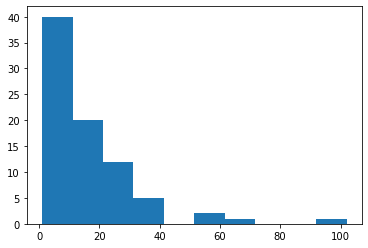

In [19]:
plt.hist([len(v) for v in metabolism_sig.values()])

CD8 T cell genes

In [6]:
file_name = data_dir + '1-s2.0-S1097276521002665-mmc6.xlsx'
different_genes_xls = pd.ExcelFile(file_name)

In [7]:
xls_sheets = [sheets for sheets in different_genes_xls.sheet_names if sheets[:2] == '5B']

# find enrichment

In [8]:
thresh = 1

In [9]:
cd8_clusters_all = {}
for sheet_name in xls_sheets:
    cd8_clusters_all[sheet_name] = pd.read_excel(file_name, sheet_name=sheet_name)

In [10]:
cd8_clusters_all['5BA_diffexpr-nonnaive-cluster1']

,index,log2FC,x_mean,y_mean,pval,padj
0,Ccl5,1.777520,394.198400,114.934845,0.000000e+00,0.000000e+00
1,Cd7,1.774166,6.941921,1.982906,1.330027e-304,7.421548e-302
2,Rgs1,1.697290,2.236003,0.643902,2.143660e-224,1.196162e-221
3,Tac1,1.250114,0.184353,0.039290,4.808361e-10,2.683065e-07
4,Sept4,1.246985,0.292190,0.084954,1.180546e-56,6.587447e-54
...,...,...,...,...,...,...
496,Hist1h2ao,-2.579769,0.114693,1.013934,1.051254e-21,5.865998e-19
497,Hist1h2ap,-2.598146,0.109936,0.998976,2.403178e-24,1.340973e-21
498,Hist1h2ag,-2.603712,0.093587,0.903714,7.290669e-27,4.068193e-24
499,Birc5,-2.713977,0.011937,0.445003,2.289729e-99,1.277669e-96


# for mouse

In [17]:
M = 9822
hypergeom_res_mouse = {k: {} for k in cd8_clusters_all.keys()}
for cd8_key in cd8_clusters_all.keys():
    df = cd8_clusters_all[cd8_key]
    df = df[df['log2FC'] > thresh]
    df['index'] = df['index'].str.upper()
    df_genes = set(df['index'])
    N = len(df) # length of DE genes
    for k,v in metabolism_sig.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)
        
        if pct_overlap > 0:
            r = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_mouse[cd8_key][k] = r
#         else:
#             hypergeom_res_mouse[cd8_key][k] = 1

/tmp/ipykernel_1303855/305200803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['index'].str.upper()


In [18]:
hypergeom_mouse_df = pd.DataFrame.from_dict(hypergeom_res_mouse)
hypergeom_mouse_df['term'] = hypergeom_mouse_df.index
hypergeom_mouse_df = hypergeom_mouse_df.melt('term')
hypergeom_mouse_df['p'] = hypergeom_mouse_df['value']
hypergeom_mouse_df['padj'] = adjust_p_value_fdr(hypergeom_mouse_df['p'])
hypergeom_mouse_df

,term,variable,value,p,padj
0,Chondroitin synthesis,5BA_diffexpr-nonnaive-cluster1,NaN,NaN,NaN
1,Nucleotide interconversion,5BA_diffexpr-nonnaive-cluster1,NaN,NaN,NaN
2,Folate metabolism,5BA_diffexpr-nonnaive-cluster1,NaN,NaN,NaN
3,"Glycine, serine, alanine and threonine metabolism",5BA_diffexpr-nonnaive-cluster1,NaN,NaN,NaN
4,Pyruvate metabolism,5BA_diffexpr-nonnaive-cluster1,NaN,NaN,NaN
...,...,...,...,...,...
242,Propanoate metabolism,5BS_diffexpr-nonnaive-cluster21,NaN,NaN,NaN
243,Inositol phosphate metabolism,5BS_diffexpr-nonnaive-cluster21,NaN,NaN,NaN
244,"Transport, extracellular",5BS_diffexpr-nonnaive-cluster21,NaN,NaN,NaN
245,Tetrahydrobiopterin metabolism,5BS_diffexpr-nonnaive-cluster21,NaN,NaN,NaN


Text(0.5, 1.0, 'cd8_atlas_rxn_genes_all')

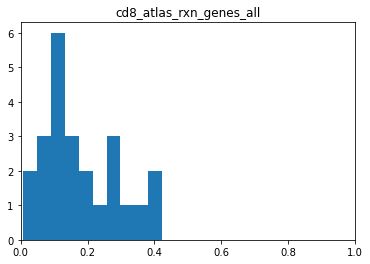

In [19]:
# p value distribution
p_all = hypergeom_mouse_df['p'][hypergeom_mouse_df['p'].notna()]
plt.hist(p_all)
plt.xlim(0,1)
plt.title('cd8_atlas_rxn_genes_all')

In [20]:
hypergeom_mouse_df[hypergeom_mouse_df['padj'] < 0.05]

,term,variable,value,p,padj


## remove non-captured genes

In [21]:
all_genes = list(pd.read_csv(data_dir + 'genes_captured_all.csv', header = None)[1][1:])
all_genes

['0610007P14RIK',
 '0610009B22RIK',
 '0610009L18RIK',
 '0610009O20RIK',
 '0610010F05RIK',
 '0610010K14RIK',
 '0610012G03RIK',
 '0610030E20RIK',
 '0610037L13RIK',
 '1110002L01RIK',
 '1110004E09RIK',
 '1110004F10RIK',
 '1110008F13RIK',
 '1110008P14RIK',
 '1110012L19RIK',
 '1110032A03RIK',
 '1110034G24RIK',
 '1110037F02RIK',
 '1110038B12RIK',
 '1110038F14RIK',
 '1110059E24RIK',
 '1110059G10RIK',
 '1110065P20RIK',
 '1190002N15RIK',
 '1190007I07RIK',
 '1300002E11RIK',
 '1500004A13RIK',
 '1500009L16RIK',
 '1500011B03RIK',
 '1500011K16RIK',
 '1500015A07RIK',
 '1600002K03RIK',
 '1600012H06RIK',
 '1600014C10RIK',
 '1600020E01RIK',
 '1700001O22RIK',
 '1700007L15RIK',
 '1700008J07RIK',
 '1700012D14RIK',
 '1700017B05RIK',
 '1700019D03RIK',
 '1700020I14RIK',
 '1700020L24RIK',
 '1700021A07RIK',
 '1700021F05RIK',
 '1700025G04RIK',
 '1700028E10RIK',
 '1700034I23RIK',
 '1700037C18RIK',
 '1700037H04RIK',
 '1700047I17RIK2',
 '1700048O20RIK',
 '1700052K11RIK',
 '1700056E22RIK',
 '1700058P15RIK',
 '1700066

In [22]:
overlapping_terms, n_removed_terms = get_overlapping_met_genes(metabolism_sig, all_genes, verb = True)

Fatty acid oxidation	original: 32 | overlapping: 19 | removed: 13
Nucleotide interconversion	original: 102 | overlapping: 52 | removed: 50
Keratan sulfate degradation	original: 11 | overlapping: 11 | removed: 0
Sphingolipid metabolism	original: 29 | overlapping: 17 | removed: 12
Tyrosine metabolism	original: 34 | overlapping: 7 | removed: 27
Keratan sulfate synthesis	original: 15 | overlapping: 8 | removed: 7
Steroid metabolism	original: 25 | overlapping: 4 | removed: 21
Chondroitin synthesis	original: 30 | overlapping: 14 | removed: 16
Tryptophan metabolism	original: 36 | overlapping: 13 | removed: 23
Glycerophospholipid metabolism	original: 61 | overlapping: 31 | removed: 30
Inositol phosphate metabolism	original: 60 | overlapping: 35 | removed: 25
Folate metabolism	original: 11 | overlapping: 7 | removed: 4
Valine, leucine, and isoleucine metabolism	original: 31 | overlapping: 27 | removed: 4
Chondroitin sulfate degradation	original: 10 | overlapping: 10 | removed: 0
Cholesterol met

In [23]:
prop_removed = {}
for k,v in n_removed_terms.items():
    prop_removed[k] = (len(metabolism_sig[k]) - v)/len(metabolism_sig[k])

Text(0.5, 0, 'proportion_retained')

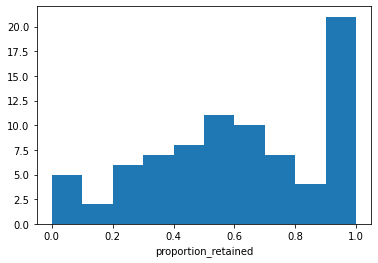

In [24]:
plt.hist(prop_removed.values())
plt.xlabel('proportion_retained')

Text(0.5, 0, 'n genes removed')

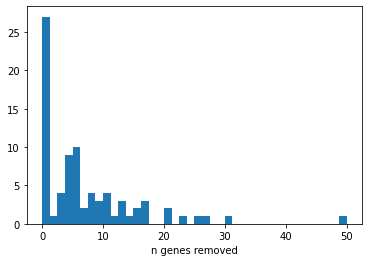

In [25]:
plt.hist(n_removed_terms.values(), bins = 40)
#plt.xlim(0,100)
plt.xlabel('n genes removed')

In [26]:
# remove keys without genes
for k in [k for k,v in overlapping_terms.items() if len(v) == 0]:
    print(k)
    overlapping_terms.pop(k)

Bile acid synthesis
Cytochrome metabolism
Alkaloid synthesis
Stilbene, coumarine and lignin synthesis
D-alanine metabolism


In [32]:
M = 9822
hypergeom_res_mouse_overlap = {k: {} for k in cd8_clusters_all.keys()}
for cd8_key in cd8_clusters_all.keys():
    df = cd8_clusters_all[cd8_key]
    df = df[df['log2FC'] > thresh]
    df['index'] = df['index'].str.upper()
    df_genes = set(df['index'])
    N = len(df) # length of DE genes
    for k,v in overlapping_terms.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)
        
        if pct_overlap > 0:
            r = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_mouse_overlap[cd8_key][k] = r
#         else:
#             hypergeom_res_mouse_overlap[cd8_key][k] = 1

/tmp/ipykernel_1303855/2647942798.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['index'].str.upper()


In [39]:
hypergeom_mouse_overlap_df = pd.DataFrame.from_dict(hypergeom_res_mouse_overlap)
hypergeom_mouse_overlap_df['term'] = hypergeom_mouse_overlap_df.index
hypergeom_mouse_overlap_df = hypergeom_mouse_overlap_df.melt('term')
hypergeom_mouse_overlap_df['p'] = hypergeom_mouse_overlap_df['value']
hypergeom_mouse_overlap_df['padj'] = adjust_p_value_bh(hypergeom_mouse_overlap_df['p'].values)
hypergeom_mouse_overlap_df['q'] = adjust_p_value_qval(hypergeom_mouse_overlap_df['p'].values,pi_0=None)
hypergeom_mouse_overlap_df[hypergeom_mouse_overlap_df['p'] < 1]

,term,variable,value,p,padj,q
13,Chondroitin synthesis,5BB_diffexpr-nonnaive-cluster2,0.056917,0.056917,NaN,0.0
40,Nucleotide interconversion,5BD_diffexpr-nonnaive-cluster4,0.001824,0.001824,NaN,0.0
41,Folate metabolism,5BD_diffexpr-nonnaive-cluster4,0.113150,0.113150,NaN,0.0
42,"Glycine, serine, alanine and threonine metabolism",5BD_diffexpr-nonnaive-cluster4,0.157657,0.157657,NaN,0.0
43,Pyruvate metabolism,5BD_diffexpr-nonnaive-cluster4,0.226955,0.226955,NaN,0.0
44,Eicosanoid metabolism,5BD_diffexpr-nonnaive-cluster4,0.082187,0.082187,NaN,0.0
45,Methionine and cysteine metabolism,5BD_diffexpr-nonnaive-cluster4,0.226955,0.226955,NaN,0.0
46,Glyoxylate and dicarboxylate metabolism,5BD_diffexpr-nonnaive-cluster4,0.186088,0.186088,NaN,0.0
47,Propanoate metabolism,5BD_diffexpr-nonnaive-cluster4,0.171994,0.171994,NaN,0.0
66,Nucleotide interconversion,5BF_diffexpr-nonnaive-cluster6,0.151945,0.151945,NaN,0.0


Text(0.5, 1.0, 'cd8_atlas_rxn_genes_rm')

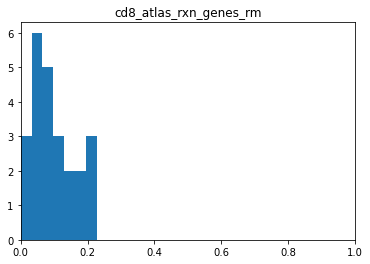

In [34]:
p_all = hypergeom_mouse_overlap_df['p'][hypergeom_mouse_overlap_df['p'].notna()]
plt.hist(p_all, bins = 7)
plt.xlim(0,1)
plt.title('cd8_atlas_rxn_genes_rm')

In [40]:
hypergeom_mouse_overlap_df[hypergeom_mouse_overlap_df['q'] < 0.05]

,term,variable,value,p,padj,q
13,Chondroitin synthesis,5BB_diffexpr-nonnaive-cluster2,0.056917,0.056917,NaN,0.0
40,Nucleotide interconversion,5BD_diffexpr-nonnaive-cluster4,0.001824,0.001824,NaN,0.0
41,Folate metabolism,5BD_diffexpr-nonnaive-cluster4,0.113150,0.113150,NaN,0.0
42,"Glycine, serine, alanine and threonine metabolism",5BD_diffexpr-nonnaive-cluster4,0.157657,0.157657,NaN,0.0
43,Pyruvate metabolism,5BD_diffexpr-nonnaive-cluster4,0.226955,0.226955,NaN,0.0
44,Eicosanoid metabolism,5BD_diffexpr-nonnaive-cluster4,0.082187,0.082187,NaN,0.0
45,Methionine and cysteine metabolism,5BD_diffexpr-nonnaive-cluster4,0.226955,0.226955,NaN,0.0
46,Glyoxylate and dicarboxylate metabolism,5BD_diffexpr-nonnaive-cluster4,0.186088,0.186088,NaN,0.0
47,Propanoate metabolism,5BD_diffexpr-nonnaive-cluster4,0.171994,0.171994,NaN,0.0
66,Nucleotide interconversion,5BF_diffexpr-nonnaive-cluster6,0.151945,0.151945,NaN,0.0


In [41]:
hypergeom_mouse_overlap_df.to_csv(out_dir + 'hypergeom_results_cd8_compass_reactions_overlap_q.csv')

# view all results

In [48]:
hypergeom_mouse_df.to_csv(out_dir + 'hypergeom_results_cd8_compass_reactions.csv')
hypergeom_mouse_overlap_df.to_csv(out_dir + 'hypergeom_results_cd8_compass_reactions_overlap.csv')

In [49]:
hypergeom_mouse_df[hypergeom_mouse_df['padj'] < 0.05]

,term,variable,value,p,padj
1378,Nucleotide interconversion,5BR_diffexpr-nonnaive-cluster20,0.007942,0.007942,0.025571


In [50]:
hypergeom_mouse_overlap_df[hypergeom_mouse_overlap_df['padj'] < 0.05]

,term,variable,value,p,padj
229,Nucleotide interconversion,5BD_diffexpr-nonnaive-cluster4,0.001824,0.001824,0.003277
557,Eicosanoid metabolism,5BH_diffexpr-nonnaive-cluster9,0.034147,0.034147,0.043215
1293,Nucleotide interconversion,5BR_diffexpr-nonnaive-cluster20,0.000676,0.000676,0.002176
